# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

### Importing necessary libraries

In [1]:
import numpy as np
import os
import h5py
import torch 
import torch.nn as nn
from tqdm import trange
import matplotlib.pyplot as plt
from torch.autograd import grad, Variable
from torch.utils.data import Dataset, DataLoader
from utils_code.dpe_A_solver import solve_dpe
from utils_code.animation import create_animation

torch.manual_seed(1234)

current_workspace = os.getcwd()
device = 'cpu'
dtype = torch.float32

### Creating and importing the data 

Due to the difficulties of working with a discontinues function of E(x), a smoothen and continues version has been designed to improve the performance of the results. The eps parameter of this new function controls how much smootheness is applied, being identical to the one given for a value of eps=0.

In [2]:
def E_real(x, phase1=2.0, phase2=5.0):
    '''Young's modulus function'''
    return np.where(np.abs(x-0.5)<0.35, np.where(np.abs(x-0.5)>0.15, phase2, phase1), phase1)

def E_smooth(x, pashe_1 = 2.0, pashe_2 = 5.0, eps = 0.02):
    '''Smoothen Young's modulus function'''
    return pashe_1 + (pashe_2-pashe_1)*((0.5*(np.tanh((x-0.15)/eps)+1)*0.5*(1-np.tanh((x-0.35)/eps))) + (0.5*(np.tanh((x-0.65)/eps)+1)*0.5*(1-np.tanh((x-0.85)/eps))))

def plot_E(eps=0):
    x = np.linspace(0., 1., 1000)
    e_real = E_real(x)
    e_smooth = E_smooth(x, eps=eps)
    
    plt.figure()
    plt.plot(x, e_real)
    plt.plot(x, e_smooth)
    plt.plot()
    plt.title("The Young's modulus E(x)")
    plt.xlabel("x")
    plt.ylabel("E(x)")
    plt.grid(True)
    plt.show()

Getting the data from the dataset file and creating boundary and collocation points

In [3]:
def get_data(nc, filepath='Datasets/LinearElasticity1d.h5'):
    lb, ub = [0.], [1.]
    np.random.seed(1234)
    
    ################################# The boundary points (x=0) and (x=1)
    x_lb = np.array(lb)
    x_rb = np.array(ub)
    #
    x_bd = np.vstack([x_lb, x_rb])
    x_bd = torch.tensor(x_bd, dtype=dtype)
    u_bd = torch.tensor([[0.], [0.]], dtype=dtype)

    ################################# The collocation points (x)
    x_in = np.random.uniform(lb, ub, nc).reshape(-1,1)
    x_in = torch.tensor(x_in, dtype=dtype)

    ################################# The testing dataset (x,u)
    with h5py.File(filepath) as data:
        x_test = torch.tensor(np.array(data["x_test"]), dtype=dtype) 
        u_test =torch.tensor( np.array(data["u_test"]), dtype=dtype)

    return x_bd, x_in, x_test, u_bd, u_test

def plot_data(nc, filepath='Datasets/LinearElasticity1d.h5'):
    x_bd, x_in, x_test, u_bd, u_test = get_data(nc, filepath)
    print('Size of boundary points:', x_bd.shape)
    print('Size of collocation points:', x_in.shape)
    print('Size of testing points:', x_test.shape)

    plt.figure(figsize=(6,5))
    plt.scatter(x_test, u_test,label='Testing data', linewidth=0.1)
    plt.scatter(x_in, torch.zeros_like(x_in), label='collocation points', linewidth=0.1)
    plt.scatter(x_bd, u_bd, color='r', label='boundary ppints')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.show()

In [4]:
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

### Building the arquitecture of the NN

Using a multi layer perceptron model withn tanh as activation function

In [5]:
class MLP(nn.Module):
    
    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        self.activation = nn.Tanh() # Activation

        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)

        # Output layer
        x = self.net[-1](x)
        
        return x

### Defining the loss class of the PINN

In [6]:
class LossClass(object):
    
    def __init__(self, u_model, eps):
        self.device = device
        self.u_model = u_model
        self.getLoss = torch.nn.MSELoss()
        self.eps = eps
    
    def loss_bd(self, x_bd, u_bd):
        '''loss term related to boundary conditions'''
        x_bd = x_bd.to(self.device)
        u = self.u_model(x_bd)
        loss = self.getLoss(u, u_bd.to(self.device))
        
        return loss 
        
    def loss_pde(self, x_in):
        '''loss term related to the PDE'''
        loss = 0. 
        
        ################# The PDE loss
        x = Variable(x_in, requires_grad=True).to(self.device)
        u = self.u_model(x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # E(x)
        E = 2.0 + (5.0-2.0)*((0.5*(torch.tanh((x-0.15)/self.eps)+1)*0.5*(1-torch.tanh((x-0.35)/self.eps))) + (0.5*(torch.tanh((x-0.65)/self.eps)+1)*0.5*(1-torch.tanh((x-0.85)/self.eps))))
        s = E * du_dx
        ds_dx = grad(inputs=x, outputs=s, grad_outputs=torch.ones_like(s), create_graph=True)[0]
        
        # f(x)
        f = 9.81
        
        # The residuals
        residual = - ds_dx - f
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual))
        
        return loss

    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test).squeeze()
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))

### Builfding the traing function

In [7]:
############ The training process
def train_PINN(hiperpameters, save_every=None, max_every=None):
    if not max_every: max_every = hiperpameters['epochs']
    if save_every: os.makedirs('model_A_progress', exist_ok=True)
    x_bd, x_in, x_test, u_bd, u_test = get_data(nc=hiperpameters['nc'])
    dataloader = DataLoader(MyDataset(x_in), batch_size=hiperpameters['batch_size'], shuffle=True)
    model_u = MLP(hiperpameters['layers_list'], dtype=torch.float32).to(device)
    optimizer = torch.optim.Adam(params=model_u.parameters(), lr=hiperpameters['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(hiperpameters['epochs']/hiperpameters['scheduler_step']), gamma=0.5)

    loss_list = []
    error_list = []
    best_error = np.inf
    for epoch in trange(hiperpameters['epochs']):
        loss = 0
        for x_batch in dataloader:
            lossClass = LossClass(model_u, hiperpameters['eps'])
            ############# Calculate losses
            loss_bd = lossClass.loss_bd(x_bd, u_bd)
            loss_in = lossClass.loss_pde(x_batch)
            loss_train = hiperpameters['w_pde']*loss_in + hiperpameters['w_bd']*loss_bd
            #
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            loss += loss_train

        # Save loss
        loss = loss/len(dataloader)
        loss_list.append(loss.item())

        # Compute error
        with torch.no_grad():
            error = lossClass.get_error(x_test, u_test)
            error_list.append(error.item())
        
        # Saving parameters of best model so far
        if error.item() < best_error:
            model_dict = model_u.state_dict()
        
        scheduler.step()  # Adjust learning rate
        if save_every:
             if (epoch+1)%save_every ==0 and (epoch+1) < max_every :
                torch.save(model_dict, f"model_A_progress/model_epoch{epoch}_error_{error}.pth")

        if (epoch+1)%25==0:
            print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, l2 error: {error.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
    
    # Saving the best model
    if model_dict:
        os.makedirs('Models', exist_ok=True)
        torch.save(model_dict, f"Models/best_model_A_eps_{hiperpameters['eps']}.pth")

    return loss_list, error_list

### Creating plot functions

For results

In [8]:
def plot_results(nc, eps, model_u, error_list, loss_list):
    def E_eps(x):
        return E_smooth(x, eps=eps)
    
    _, _, x_test, _, u_test = get_data(nc=nc)
    
    u_query = model_u(x_test.to(device)).detach().cpu()
    u_smooth = solve_dpe(x_test.numpy().squeeze(), E_eps)
    error = torch.sqrt(torch.sum((u_test-u_query.T)**2)/torch.sum(u_test**2))
    
    plt.figure(figsize=(6, 4))
    plt.semilogy(loss_list, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    axes[0].plot(x_test, u_query, marker='o', markersize=2, label='Pred. u')
    axes[0].plot(x_test, u_test, label='True u')
    axes[0].plot(x_test, u_smooth, label='True u smooth', color='r')
    axes[0].set_title(f'$L^2$ relative error is:{error}')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('u')
    axes[0].legend()
    #
    axes[1].semilogy(error_list, label='$L^2$ relative error')
    axes[1].set_title('$L^2$ relative error vs. epochs')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('error')
    axes[1].legend()
    #
    plt.show()

For animation of the training process

In [9]:
def progress_animation(nc, eps, model):
    os.makedirs('model_A_frames', exist_ok=True)
    def E_eps(x):
        return E_smooth(x, eps=eps)
    
    def extract_epoch(filename):
        return int(filename.split('epoch')[1].split('_')[0])
    
    def extract_error(filename):
        return float(filename.split('_error_')[-1].split('.pth')[0])
    
    _, _, x_test, _, u_test = get_data(nc=nc)
    
    u_smooth = solve_dpe(x_test.numpy().squeeze(), E_eps)

    error_list = []
    files = [f for f in os.listdir('model_A_progress') if f.endswith(".pth")]
    files_sorted = sorted(files, key=extract_epoch)
    for i, filename in enumerate(files_sorted):
        if filename.split('.')[-1] == 'pth':
            epoch = extract_epoch(filename)
            error = extract_error(filename)
            error_list.append(error)
            model_trained = model.to(device)  
            model_trained.load_state_dict(torch.load(f'model_A_progress/{filename}'))    

            u_query = model_trained(x_test.to(device)).detach().cpu()

            fig, axes = plt.subplots(1, 2, figsize=(12,5))
            axes[0].plot(x_test, u_query, marker='o', markersize=2, label='Pred. u')
            axes[0].plot(x_test, u_test, label='True u')
            axes[0].plot(x_test, u_smooth, label='True u smooth', color='r')
            axes[0].set_title(f'Epoch = {epoch}')
            axes[0].set_xlabel('x')
            axes[0].set_ylabel('u')
            axes[0].legend()
            #
            axes[1].semilogy(error_list, label='$L^2$ relative error')
            axes[1].set_title(f'Error at epoch = {error}')
            axes[1].set_xlabel('epoch')
            axes[1].set_ylabel('error')
            axes[1].legend()
            plt.savefig(f"model_A_frames/frame_{i:03d}.png")
            plt.close(fig)

### Solving for eps 0.02

#### Defining the hyperparameters

In [10]:
hiperparams = {
'batch_size': 1000,
'scheduler_step': 10,
'epochs': 500,
'lr': 3e-3,
'layers_list': [1, 60, 40, 40, 1],
'eps': 0.02, 
'w_pde': 5.,
'w_bd': 2.,
'nc': 150000,
}
hiperparams = {
'batch_size': 1000,
'scheduler_step': 10,
'epochs': 500,
'lr': 3e-3,
'layers_list': [1, 60, 40, 40, 1],
'eps': 0.02, 
'w_pde': 5.,
'w_bd': 2.,
'nc': 150000,
}

#### Plotting the data

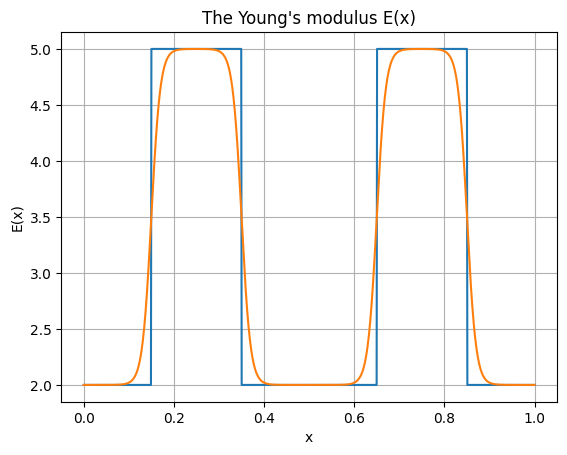

Size of boundary points: torch.Size([2, 1])
Size of collocation points: torch.Size([150000, 1])
Size of testing points: torch.Size([1001, 1])


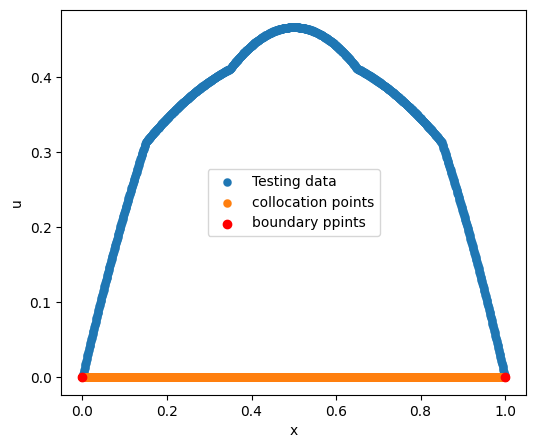

In [11]:
plot_E(eps=hiperparams['eps'])
plot_data(nc=hiperparams['nc'])

#### Training the PINN

save_every allows to save a model every define number of epoch and allows to create an animation later. max_every allows to save models up to a defined number of epochs in case save_every is defined.


In [12]:
loss_list, error_list = train_PINN(hiperparams, save_every=None, max_every=None)

  5%|▌         | 25/500 [00:16<04:42,  1.68it/s]

Epoch:24, The loss is:3.3439993858337402, l2 error: 0.38713666796684265, lr: 0.003


 10%|█         | 50/500 [00:31<04:25,  1.69it/s]

Epoch:49, The loss is:2.8208649158477783, l2 error: 0.3211723864078522, lr: 0.0015


 15%|█▌        | 75/500 [00:46<04:09,  1.70it/s]

Epoch:74, The loss is:0.21284297108650208, l2 error: 0.14883877336978912, lr: 0.0015


 20%|██        | 100/500 [01:01<03:57,  1.69it/s]

Epoch:99, The loss is:0.05984161049127579, l2 error: 0.07808002084493637, lr: 0.00075


 25%|██▌       | 125/500 [01:16<03:43,  1.68it/s]

Epoch:124, The loss is:0.18156495690345764, l2 error: 0.04515113681554794, lr: 0.00075


 30%|███       | 150/500 [01:31<03:21,  1.74it/s]

Epoch:149, The loss is:0.03254707530140877, l2 error: 0.04437502473592758, lr: 0.000375


 35%|███▌      | 175/500 [01:46<03:13,  1.68it/s]

Epoch:174, The loss is:0.03325147181749344, l2 error: 0.03621452674269676, lr: 0.000375


 40%|████      | 200/500 [02:02<03:19,  1.50it/s]

Epoch:199, The loss is:0.01793668046593666, l2 error: 0.037267979234457016, lr: 0.0001875


 45%|████▌     | 225/500 [02:19<03:09,  1.45it/s]

Epoch:224, The loss is:0.017902711406350136, l2 error: 0.03125528246164322, lr: 0.0001875


 50%|█████     | 250/500 [02:34<02:31,  1.65it/s]

Epoch:249, The loss is:0.016356896609067917, l2 error: 0.02822081185877323, lr: 9.375e-05


 55%|█████▌    | 275/500 [02:49<02:11,  1.71it/s]

Epoch:274, The loss is:0.013708068057894707, l2 error: 0.02816632203757763, lr: 9.375e-05


 60%|██████    | 300/500 [03:05<01:56,  1.72it/s]

Epoch:299, The loss is:0.010460305958986282, l2 error: 0.027096649631857872, lr: 4.6875e-05


 65%|██████▌   | 325/500 [03:21<01:56,  1.51it/s]

Epoch:324, The loss is:0.009958019480109215, l2 error: 0.027718262746930122, lr: 4.6875e-05


 70%|███████   | 350/500 [03:35<01:23,  1.80it/s]

Epoch:349, The loss is:0.01025016512721777, l2 error: 0.027042068541049957, lr: 2.34375e-05


 75%|███████▌  | 375/500 [03:49<01:09,  1.80it/s]

Epoch:374, The loss is:0.008039150387048721, l2 error: 0.02808338589966297, lr: 2.34375e-05


 80%|████████  | 400/500 [04:04<01:02,  1.60it/s]

Epoch:399, The loss is:0.007693396881222725, l2 error: 0.028445295989513397, lr: 1.171875e-05


 85%|████████▌ | 425/500 [04:20<00:44,  1.68it/s]

Epoch:424, The loss is:0.007760321255773306, l2 error: 0.027569476515054703, lr: 1.171875e-05


 90%|█████████ | 450/500 [04:35<00:30,  1.63it/s]

Epoch:449, The loss is:0.00714595802128315, l2 error: 0.02779480628669262, lr: 5.859375e-06


 95%|█████████▌| 475/500 [04:51<00:15,  1.62it/s]

Epoch:474, The loss is:0.006935540586709976, l2 error: 0.027752641588449478, lr: 5.859375e-06


100%|██████████| 500/500 [05:06<00:00,  1.63it/s]

Epoch:499, The loss is:0.006920988205820322, l2 error: 0.027542199939489365, lr: 2.9296875e-06


#### Plotting results

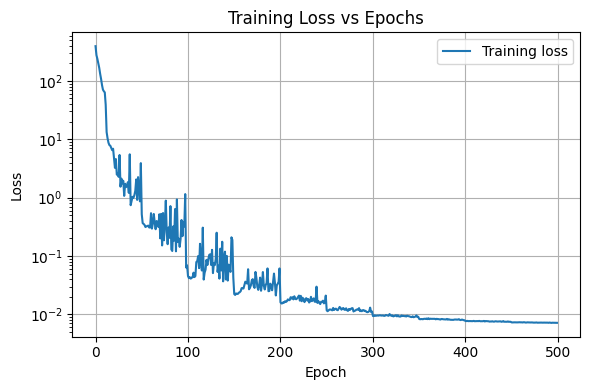

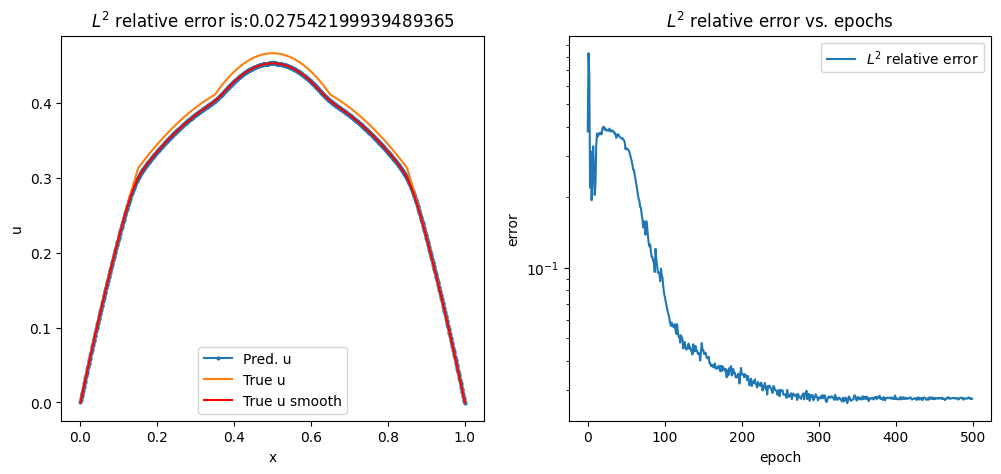

In [13]:
model_trained = MLP(hiperparams['layers_list']).to(device)  
model_trained.load_state_dict(torch.load(f'Models/best_model_A_eps_{hiperparams['eps']}.pth'))
plot_results(nc=hiperparams['nc'], eps=hiperparams['eps'], model_u=model_trained, error_list=error_list, loss_list=loss_list)

#### Creating animation of training

Creates an animation of the training process, requires using save_every to be set in the training process

In [14]:
create = False
if create:
    model = MLP(hiperparams['layers_list']).to(device) 
    progress_animation(nc=hiperparams['nc'], eps=hiperparams['eps'], model=model)
    create_animation('Model_A_animation_eps_0.002')

![Nombre alternativo](Results/Animations/Model_A_animation_eps_0.02.gif)

### Solving for eps 0.01

#### Defining the hyperparameters

In [23]:
hiperparams = {
'batch_size': 1000,
'scheduler_step': 16,
'epochs': 800,
'lr': 3e-3,
'layers_list': [1, 60, 40, 40, 1],
'eps': 0.01, 
'w_pde': 4.,
'w_bd': 3., 
'nc': 350000,
}

#### Plotting the data

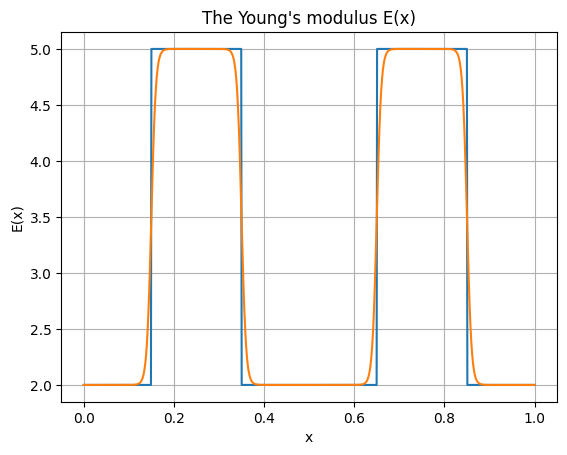

Size of boundary points: torch.Size([2, 1])
Size of collocation points: torch.Size([350000, 1])
Size of testing points: torch.Size([1001, 1])


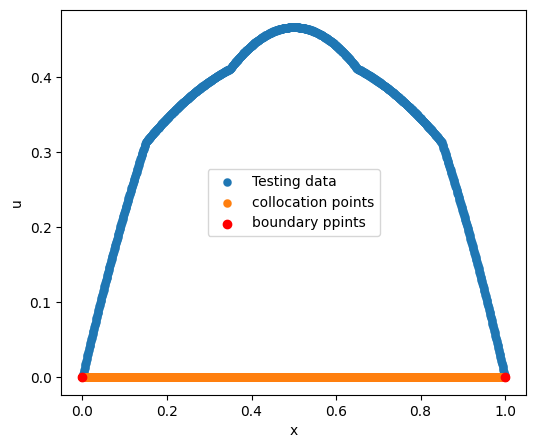

In [24]:
plot_E(eps=hiperparams['eps'])
plot_data(nc=hiperparams['nc'])

#### Training the PINN

In [25]:
loss_list, error_list = train_PINN(hiperparams, save_every=None, max_every=None)

  3%|▎         | 25/800 [00:38<19:58,  1.55s/it]

Epoch:24, The loss is:7.570669174194336, l2 error: 0.3971898853778839, lr: 0.003


  6%|▋         | 50/800 [01:17<19:14,  1.54s/it]

Epoch:49, The loss is:5.67100191116333, l2 error: 0.2643296420574188, lr: 0.0015


  9%|▉         | 75/800 [01:55<18:29,  1.53s/it]

Epoch:74, The loss is:0.19776925444602966, l2 error: 0.04187827929854393, lr: 0.0015


 12%|█▎        | 100/800 [02:33<17:29,  1.50s/it]

Epoch:99, The loss is:0.18830381333827972, l2 error: 0.057146940380334854, lr: 0.00075


 16%|█▌        | 125/800 [03:11<16:37,  1.48s/it]

Epoch:124, The loss is:0.08186409622430801, l2 error: 0.017459681257605553, lr: 0.00075


 19%|█▉        | 150/800 [03:50<16:32,  1.53s/it]

Epoch:149, The loss is:0.07263832539319992, l2 error: 0.024441003799438477, lr: 0.000375


 22%|██▏       | 175/800 [04:28<16:04,  1.54s/it]

Epoch:174, The loss is:0.07812550663948059, l2 error: 0.01920890435576439, lr: 0.000375


 25%|██▌       | 200/800 [05:06<14:49,  1.48s/it]

Epoch:199, The loss is:0.025984054431319237, l2 error: 0.014351320452988148, lr: 0.0001875


 28%|██▊       | 225/800 [05:44<15:15,  1.59s/it]

Epoch:224, The loss is:0.03410044312477112, l2 error: 0.018835950642824173, lr: 0.0001875


 31%|███▏      | 250/800 [06:22<14:08,  1.54s/it]

Epoch:249, The loss is:0.0364699512720108, l2 error: 0.01902787573635578, lr: 9.375e-05


 34%|███▍      | 275/800 [07:02<14:10,  1.62s/it]

Epoch:274, The loss is:0.015148995444178581, l2 error: 0.01881398819386959, lr: 9.375e-05


 38%|███▊      | 300/800 [07:38<11:50,  1.42s/it]

Epoch:299, The loss is:0.018074722960591316, l2 error: 0.0186427254229784, lr: 4.6875e-05


 41%|████      | 325/800 [08:14<11:52,  1.50s/it]

Epoch:324, The loss is:0.012192295864224434, l2 error: 0.018333256244659424, lr: 4.6875e-05


 44%|████▍     | 350/800 [08:51<11:06,  1.48s/it]

Epoch:349, The loss is:0.010434068739414215, l2 error: 0.017741700634360313, lr: 2.34375e-05


 47%|████▋     | 375/800 [09:27<10:14,  1.45s/it]

Epoch:374, The loss is:0.011891987174749374, l2 error: 0.017421722412109375, lr: 2.34375e-05


 50%|█████     | 400/800 [10:03<09:14,  1.39s/it]

Epoch:399, The loss is:0.013307904824614525, l2 error: 0.01692221313714981, lr: 1.171875e-05


 53%|█████▎    | 425/800 [10:40<08:56,  1.43s/it]

Epoch:424, The loss is:0.010507163591682911, l2 error: 0.016942638903856277, lr: 1.171875e-05


 56%|█████▋    | 450/800 [11:18<09:40,  1.66s/it]

Epoch:449, The loss is:0.012336088344454765, l2 error: 0.01698363572359085, lr: 5.859375e-06


 59%|█████▉    | 475/800 [11:56<08:16,  1.53s/it]

Epoch:474, The loss is:0.011085734702646732, l2 error: 0.016785671934485435, lr: 5.859375e-06


 62%|██████▎   | 500/800 [12:34<07:30,  1.50s/it]

Epoch:499, The loss is:0.009405282326042652, l2 error: 0.01657726988196373, lr: 2.9296875e-06


 66%|██████▌   | 525/800 [13:16<07:00,  1.53s/it]

Epoch:524, The loss is:0.010209880769252777, l2 error: 0.01657211221754551, lr: 2.9296875e-06


 69%|██████▉   | 550/800 [13:53<05:58,  1.43s/it]

Epoch:549, The loss is:0.010836055502295494, l2 error: 0.01654810644686222, lr: 1.46484375e-06


 72%|███████▏  | 575/800 [14:28<05:13,  1.40s/it]

Epoch:574, The loss is:0.00906449556350708, l2 error: 0.01651788502931595, lr: 1.46484375e-06


 75%|███████▌  | 600/800 [15:04<04:49,  1.45s/it]

Epoch:599, The loss is:0.008960969746112823, l2 error: 0.01641610451042652, lr: 7.32421875e-07


 78%|███████▊  | 625/800 [15:41<04:07,  1.41s/it]

Epoch:624, The loss is:0.010023193433880806, l2 error: 0.01649494282901287, lr: 7.32421875e-07


 81%|████████▏ | 650/800 [16:17<03:48,  1.53s/it]

Epoch:649, The loss is:0.011675728484988213, l2 error: 0.01645081490278244, lr: 3.662109375e-07


 84%|████████▍ | 675/800 [16:53<02:56,  1.41s/it]

Epoch:674, The loss is:0.009684442542493343, l2 error: 0.016439499333500862, lr: 3.662109375e-07


 88%|████████▊ | 700/800 [17:30<02:37,  1.58s/it]

Epoch:699, The loss is:0.009055336937308311, l2 error: 0.01643568091094494, lr: 1.8310546875e-07


 91%|█████████ | 725/800 [18:09<01:56,  1.55s/it]

Epoch:724, The loss is:0.009481656365096569, l2 error: 0.016426414251327515, lr: 1.8310546875e-07


 94%|█████████▍| 750/800 [18:49<01:18,  1.57s/it]

Epoch:749, The loss is:0.008951288647949696, l2 error: 0.016430797055363655, lr: 9.1552734375e-08


 97%|█████████▋| 775/800 [19:28<00:38,  1.54s/it]

Epoch:774, The loss is:0.008748907595872879, l2 error: 0.016428256407380104, lr: 9.1552734375e-08


100%|██████████| 800/800 [20:07<00:00,  1.51s/it]

Epoch:799, The loss is:0.009559289552271366, l2 error: 0.016422957181930542, lr: 4.57763671875e-08


#### Plotting results

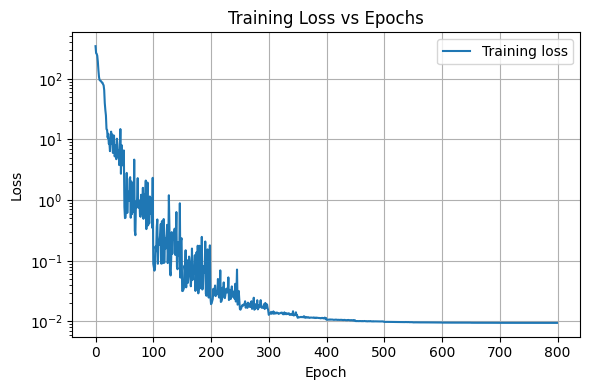

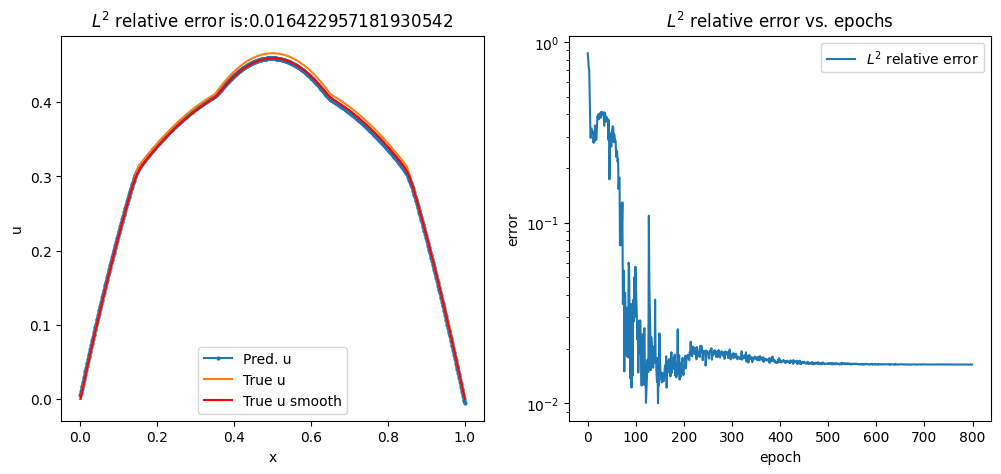

In [26]:
model_trained = MLP(hiperparams['layers_list']).to(device)  
model_trained.load_state_dict(torch.load(f'Models/best_model_A_eps_{hiperparams['eps']}.pth'))
plot_results(nc=hiperparams['nc'], eps=hiperparams['eps'], model_u=model_trained, error_list=error_list, loss_list=loss_list)

#### Creating animation of the training

In [ ]:
create = False
if create:
    model = MLP(hiperparams['layers_list']).to(device) 
    progress_animation(nc=hiperparams['nc'], eps=hiperparams['eps'], model=model)
    create_animation('Model_A_animation_eps_0.001')

![Animation2](Results/Animations/Model_A_animation_eps_0.01.gif)